In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import xgboost

In [3]:
import pickle

In [4]:
import util

# Problem statement

Simulate backtest, assume model predict score for July-2023 and Aug-2023, they might be overlapsed

1. Filter inactive customer in June-2023
2. Predict score for customer to be deployed, about 100.000 customer
3. Get all customer status of REACTIVATED in July-2023

# 1. Filter inactivte customer and 2. predict score

In [5]:
query1 = """
WITH 
T1 AS (
    SELECT * FROM CINS_REACTIVATED_SCORE_01072023),
T2 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT),
T3 AS (
    SELECT DISTINCT T1.*
    FROM T1
    INNER JOIN T2 ON T1.CUSTOMER_CDE = T2.CUSTOMER_CDE
    WHERE T2.PROCESS_DT = TO_DATE('30-06-23','DD-MM-YY')
    )
SELECT * FROM T3
"""

In [6]:
df = util.download_or_reload('SIM_DATA', query1)

In [7]:
df

,CUSTOMER_CDE,SCORE
0,17106067,0.999979
1,17104002,0.999994
2,13526037,0.999994
3,12641228,0.999982
4,14487484,0.999984
...,...,...
15950729,8089524,0.000037
15950730,2046663,0.000048
15950731,9276525,0.000052
15950732,8101710,0.000047


In [8]:
df['CUSTOMER_CDE'].nunique()

15950734

In [9]:
df[['CUSTOMER_CDE', 'SCORE']].drop_duplicates()

,CUSTOMER_CDE,SCORE
0,17106067,0.999979
1,17104002,0.999994
2,13526037,0.999994
3,12641228,0.999982
4,14487484,0.999984
...,...,...
15950729,8089524,0.000037
15950730,2046663,0.000048
15950731,9276525,0.000052
15950732,8101710,0.000047


In [10]:
# Threshold recommend
df.iloc[100000]['SCORE']

0.9997005462646484

In [11]:
df3 = df

In [12]:
df3

,CUSTOMER_CDE,SCORE
0,17106067,0.999979
1,17104002,0.999994
2,13526037,0.999994
3,12641228,0.999982
4,14487484,0.999984
...,...,...
15950729,8089524,0.000037
15950730,2046663,0.000048
15950731,9276525,0.000052
15950732,8101710,0.000047


# 3. Get all customer status of REACTIVATED of July-2023

In [13]:
query2 = """WITH
T0 AS (
    SELECT * FROM CINS_TMP_CUSTOMER_01072023
),
T1 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT
    WHERE PROCESS_DT = TO_DATE('30-06-2023', 'DD-MM-YY')
    OR PROCESS_DT = TO_DATE('01-06-2023', 'DD-MM-YY')
),
T2 AS (
    SELECT T0.CUSTOMER_CDE, T1.PROCESS_DT AS RPT_DT,
        MAX(CASE
            WHEN T1.CUST_STATUS = 'HOAT DONG' THEN 2
            WHEN T1.CUST_STATUS = 'NGU DONG' THEN 1
            WHEN T1.CUST_STATUS = 'DONG BANG' THEN 0
        END) AS CUST_STT
    FROM T0 
    INNER JOIN T1 ON T0.CUSTOMER_CDE = T1.CUSTOMER_CDE
    GROUP BY T0.CUSTOMER_CDE, PROCESS_DT
),
T3 AS (
    SELECT CUSTOMER_CDE, 
    RPT_DT, LAG(RPT_DT) OVER (PARTITION BY CUSTOMER_CDE ORDER BY RPT_DT) AS RPT_DT_LAG, 
    CUST_STT, LAG(CUST_STT) OVER (PARTITION BY CUSTOMER_CDE ORDER BY RPT_DT) AS CUST_STT_LAG
    FROM T2
),
T4 AS (
    SELECT CUSTOMER_CDE, 
    RPT_DT, RPT_DT_LAG,
    CUST_STT, CUST_STT_LAG, CUST_STT - CUST_STT_LAG AS CUST_STT_CHG
    FROM T3 
    WHERE RPT_DT = TO_DATE('30-06-2023', 'DD-MM-YY')
),
T5 AS (
    SELECT CUSTOMER_CDE, RPT_DT, RPT_DT_LAG, CUST_STT, CUST_STT_LAG, CUST_STT_CHG,
    CASE 
        WHEN CUST_STT = 2 AND CUST_STT_CHG >= 1 THEN 1
        WHEN CUST_STT <= 1 AND CUST_STT_LAG <= 1 THEN 0
    END AS REACTIVATED
    FROM T4
),
T6 AS (
    SELECT CUSTOMER_CDE,
    'REACTIVATED' AS FTR_NM,
    REACTIVATED AS FTR_VAL,
    TO_DATE('01-07-2023', 'DD-MM-YY') AS RPT_DT,
    CURRENT_TIMESTAMP ADD_TSTP
    FROM T5
    WHERE REACTIVATED IS NOT NULL
)
SELECT * FROM T6"""

In [14]:
gt = util.download_or_reload('SIM_DATA2', query2)

In [16]:
df4 = df3.merge(gt[['CUSTOMER_CDE', 'FTR_VAL']], how='left', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')
df4 = df4.rename(columns={'FTR_VAL': 'REACTIVATED'})
# df4['REACTIVATED'] = df4['REACTIVATED'].fillna(0)
df4

,CUSTOMER_CDE,SCORE,REACTIVATED
0,17106067,0.999979,NaN
1,17104002,0.999994,NaN
2,13526037,0.999994,NaN
3,12641228,0.999982,NaN
4,14487484,0.999984,NaN
...,...,...,...
15950729,8089524,0.000037,0.0
15950730,2046663,0.000048,0.0
15950731,9276525,0.000052,0.0
15950732,8101710,0.000047,NaN


In [17]:
df4['REACTIVATED'].value_counts(dropna=False)

NaN    8361736
0.0    7526338
1.0      62660
Name: REACTIVATED, dtype: int64

In [18]:
df4 = df4.dropna()

In [19]:
df4['REACTIVATED'].value_counts()

0.0    7526338
1.0      62660
Name: REACTIVATED, dtype: int64

In [20]:
df4.sort_values(by='SCORE', ascending=False)

,CUSTOMER_CDE,SCORE,REACTIVATED
7801418,18099696,1.000000,1.0
15888427,18114769,1.000000,1.0
1723512,18111982,1.000000,1.0
2193671,18138008,1.000000,1.0
11511044,18128220,1.000000,1.0
...,...,...,...
10047414,14483909,0.000004,0.0
11728159,14337166,0.000004,0.0
9793272,14975929,0.000004,0.0
10687323,13961761,0.000003,0.0


In [21]:
import seaborn as sns

<Axes: xlabel='SCORE', ylabel='Density'>

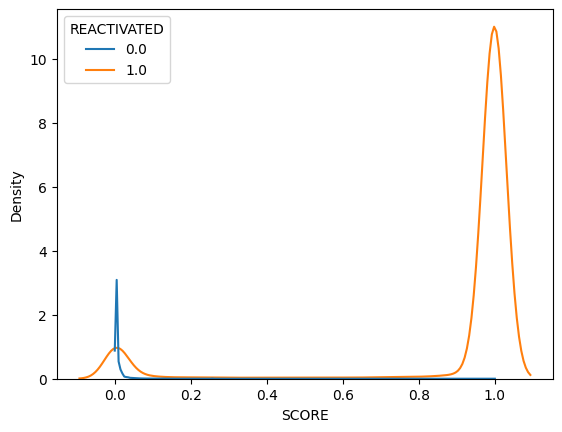

In [22]:
sns.kdeplot(df4, hue='REACTIVATED', x='SCORE', common_norm=False)

In [23]:
from sklearn import metrics

In [24]:
y_true = df4['REACTIVATED'].values
y_pred = df4['SCORE'].values

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.9801699335983436

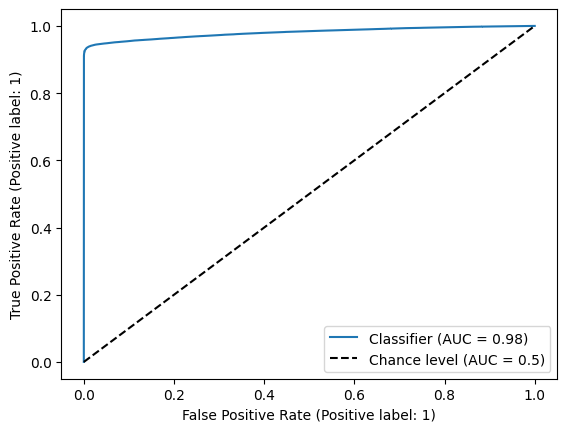

In [26]:
display = metrics.RocCurveDisplay.from_predictions(y_true, y_pred, plot_chance_level=True)